# Risk Profile Analysis: PEP (PepsiCo)

## Objective
Establish a comprehensive risk profile for PEP over a 10+ year period including:
- **Beta**: Systematic risk relative to market (SPY)
- **Total Risk**: Standard deviation of returns
- **Performance Metrics**: Jensen's Alpha, Sharpe Ratio, Treynor Ratio
- **Risk-Adjusted Returns**: Information Ratio, Sortino Ratio

## Data Period
- **Analysis Period**: 10+ years of monthly returns
- **Market Proxy**: SPY (S&P 500 ETF)
- **Risk-Free Rate**: 3-month Treasury Bill rate

In [1]:
# import libraries
import os, sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm

frequency = 'monthly'

# Set project root and change working directory
project_root = Path.cwd().parent.parent  # src/notebook/ is two levels below root
os.chdir(project_root)  # Change to project root so PriceManager can find data/
print(f"📁 Working directory: {os.getcwd()}")

# Add src directory to Python path
sys.path.insert(0, str(project_root / "src"))

from tiingo import TiingoClient
from core.config import Config
from market import PriceManager
from universe import SP500Universe

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

# Initialize configuration and components - USE ABSOLUTE PATH
config = Config(str(project_root / "config/settings.yaml"))
universe = SP500Universe()

# Initialize Tiingo client and PriceManager
tiingo = TiingoClient({
    'api_key': config.get('fetcher.tiingo.api_key'),
    'session': True
})

price_mgr = PriceManager(tiingo=tiingo, universe=universe)

print("✅ Components initialized successfully")

📁 Working directory: /Users/frank/Projects/QuantX/quantx-data-builder
✅ Libraries imported successfully
✅ Components initialized successfully
✅ Libraries imported successfully
✅ Components initialized successfully


In [2]:
'''
Load 10+ years of monthly price data for risk profile analysis
Period: 2014-01-01 to 2025-10-31 (11 years)
'''

# Load SPY (market proxy) data
spy_monthly = price_mgr.load_market_etf_data(
    frequency=frequency,
    start_date='2014-01-01',
    end_date='2025-10-31'
)

# Load PEP (target stock) data
pep_monthly = price_mgr.load_price_data(
    symbol='PEP',
    frequency=frequency,
    start_date='2014-01-01',
    end_date='2025-10-31'
)

print(f"📊 Data loaded:")
print(f"  SPY: {len(spy_monthly)} observations")
print(f"  PEP: {len(pep_monthly)} observations")
print(f"  Date range: {spy_monthly['date'].min()} to {spy_monthly['date'].max()}")

# Combine adjusted close prices
monthly_prices = pd.DataFrame({
    'PEP': pep_monthly.set_index('date')['adj_close'],
    'SPY': spy_monthly.set_index('date')['adj_close'],
})

print(f"\n📊 Monthly prices shape: {monthly_prices.shape}")
print(f"Number of matching dates: {len(monthly_prices.dropna())}")

# Calculate monthly returns
monthly_returns = monthly_prices.pct_change(1)
clean_returns = monthly_returns.dropna(axis=0)

print(f"\n📈 Monthly returns: {len(clean_returns)} observations")
print(clean_returns.head())

📊 Data loaded:
  SPY: 142 observations
  PEP: 142 observations
  Date range: 2014-01-31 to 2025-10-31

📊 Monthly prices shape: (142, 2)
Number of matching dates: 142

📈 Monthly returns: 141 observations
                 PEP       SPY
date                          
2014-02-28 -0.003609  0.045516
2014-03-31  0.050134  0.008311
2014-04-30  0.028623  0.006951
2014-05-30  0.028408  0.023206
2014-06-30  0.019012  0.020633


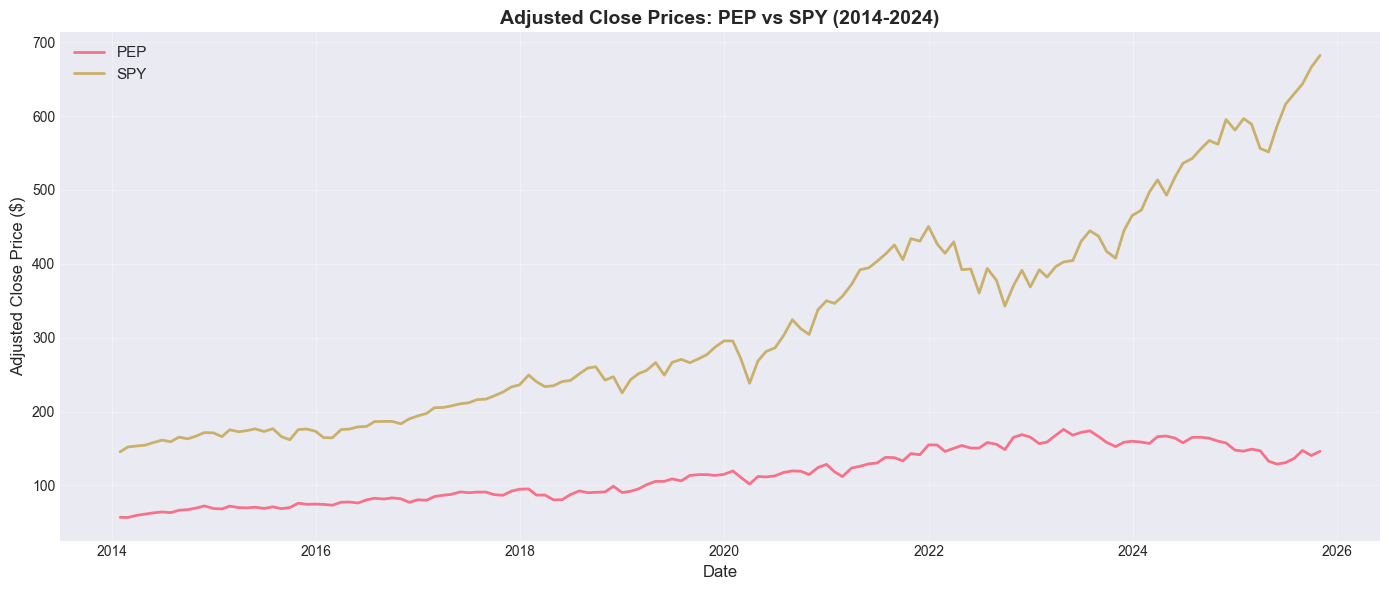

✅ Price chart plotted successfully


In [3]:
# 1. Plot cumulative prices over 10+ years
plt.figure(figsize=(14, 6))
plt.plot(monthly_prices.index, monthly_prices['PEP'], label='PEP', linewidth=2)
plt.plot(monthly_prices.index, monthly_prices['SPY'], label='SPY', linewidth=2, alpha=0.7)
plt.title('Adjusted Close Prices: PEP vs SPY (2014-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price ($)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Price chart plotted successfully")

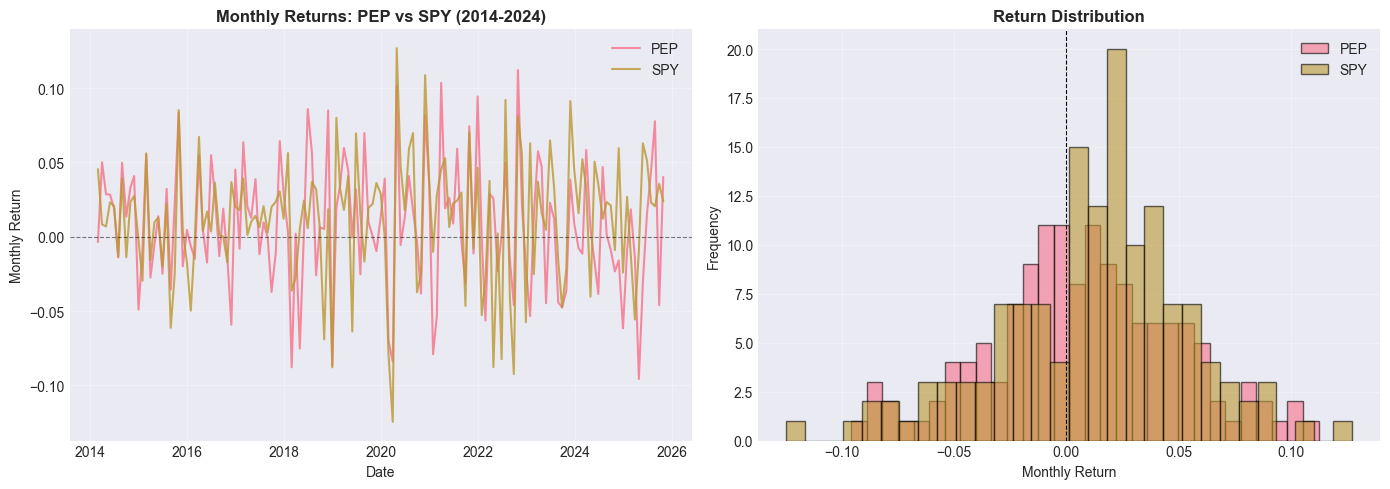


📊 Descriptive Statistics:
              PEP         SPY
count  141.000000  141.000000
mean     0.007621    0.011902
std      0.042432    0.042081
min     -0.095772   -0.124643
25%     -0.015836   -0.012695
50%      0.005188    0.017895
75%      0.035497    0.036838
max      0.112214    0.126984


In [4]:
# 2. Plot monthly returns distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series of returns
axes[0].plot(clean_returns.index, clean_returns['PEP'], label='PEP', linewidth=1.5, alpha=0.8)
axes[0].plot(clean_returns.index, clean_returns['SPY'], label='SPY', linewidth=1.5, alpha=0.8)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].set_title('Monthly Returns: PEP vs SPY (2014-2024)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Monthly Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution histogram
axes[1].hist(clean_returns['PEP'], bins=30, alpha=0.6, label='PEP', edgecolor='black')
axes[1].hist(clean_returns['SPY'], bins=30, alpha=0.6, label='SPY', edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('Return Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Monthly Return')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Descriptive Statistics:")
print(clean_returns.describe())

In [5]:
import statsmodels.api as sm

# 3. Calculate Beta using 60-month rolling window regression
print("="*70)
print("ROLLING WINDOW REGRESSION: 60-Month Window")
print("="*70)

# Parameters
window_size = 60  # 60 months = 5 years
min_periods = 36  # Minimum 3 years of data required

# Prepare data
returns_df = clean_returns[['SPY', 'PEP']].copy()

# Initialize storage for rolling regression results
rolling_results = []

# Perform rolling window regressions
for i in range(window_size - 1, len(returns_df)):
    # Extract window data
    window_data = returns_df.iloc[i - window_size + 1:i + 1]
    
    # Check if we have enough observations
    if len(window_data.dropna()) < min_periods:
        continue
    
    # Prepare X (market) and Y (stock) returns
    X = window_data['SPY'].values
    Y = window_data['PEP'].values
    
    # Run OLS regression
    X_with_const = sm.add_constant(X)
    model = sm.OLS(Y, X_with_const).fit()
    
    # Store results
    rolling_results.append({
        'date': returns_df.index[i],
        'alpha': model.params[0],
        'beta': model.params[1],
        'r_squared': model.rsquared,
        'alpha_pvalue': model.pvalues[0],
        'beta_pvalue': model.pvalues[1],
        'residual_std': model.resid.std(),
        'n_obs': len(window_data.dropna())
    })

# Convert to DataFrame
rolling_df = pd.DataFrame(rolling_results)
rolling_df.set_index('date', inplace=True)

print(f"\n📊 Rolling Regression Results:")
print(f"   Total windows: {len(rolling_df)}")
print(f"   Period: {rolling_df.index.min()} to {rolling_df.index.max()}")
print(f"   Average observations per window: {rolling_df['n_obs'].mean():.1f}")
print(f"\n📈 Summary Statistics (Rolling Parameters):")
print(rolling_df[['alpha', 'beta', 'r_squared']].describe())

# Calculate full-sample regression for comparison
X_full = clean_returns['SPY'].values
Y_full = clean_returns['PEP'].values
X_full_const = sm.add_constant(X_full)
model_full = sm.OLS(Y_full, X_full_const).fit()

print(f"\n📊 Full-Sample Regression (for comparison):")
print(f"   Alpha: {model_full.params[0]:.6f} (annualized: {model_full.params[0]*12:.4%})")
print(f"   Beta: {model_full.params[1]:.4f}")
print(f"   R-squared: {model_full.rsquared:.4f}")
print(f"   Observations: {len(clean_returns)}")

# Store full-sample results for later use
alpha_full = model_full.params[0]
beta_full = model_full.params[1]
r_squared_full = model_full.rsquared
residuals_full = model_full.resid

ROLLING WINDOW REGRESSION: 60-Month Window

📊 Rolling Regression Results:
   Total windows: 82
   Period: 2019-01-31 to 2025-10-31
   Average observations per window: 60.0

📈 Summary Statistics (Rolling Parameters):
           alpha       beta  r_squared
count  82.000000  82.000000  82.000000
mean    0.002523   0.560449   0.321495
std     0.002638   0.048390   0.054156
min    -0.002981   0.455090   0.204631
25%     0.000721   0.532914   0.291179
50%     0.003135   0.555860   0.333478
75%     0.004149   0.597609   0.366255
max     0.008672   0.656018   0.414605

📊 Full-Sample Regression (for comparison):
   Alpha: 0.001447 (annualized: 1.7367%)
   Beta: 0.5187
   R-squared: 0.2646
   Observations: 141

📊 Rolling Regression Results:
   Total windows: 82
   Period: 2019-01-31 to 2025-10-31
   Average observations per window: 60.0

📈 Summary Statistics (Rolling Parameters):
           alpha       beta  r_squared
count  82.000000  82.000000  82.000000
mean    0.002523   0.560449   0.321495


In [6]:
# 3b. Display the last rolling window regression summary
print("\n" + "="*70)
print("LAST ROLLING WINDOW REGRESSION DETAILS")
print(f"Window Period: {rolling_df.index[-60]} to {rolling_df.index[-1]}")
print("="*70)

# Get the last 60 months of data
last_window_data = returns_df.iloc[-60:]

# Run regression on last window
X_last = last_window_data['SPY'].values
Y_last = last_window_data['PEP'].values
X_last_const = sm.add_constant(X_last)
model_last = sm.OLS(Y_last, X_last_const).fit()

# Display full regression summary
print(model_last.summary())

# Additional interpretation
print("\n" + "="*70)
print("INTERPRETATION OF LAST WINDOW")
print("="*70)
print(f"Alpha (Monthly): {model_last.params[0]:.6f}")
print(f"Alpha (Annualized): {model_last.params[0]*12:.4%}")
print(f"Beta: {model_last.params[1]:.4f}")
print(f"R-squared: {model_last.rsquared:.4f}")
print(f"Adjusted R-squared: {model_last.rsquared_adj:.4f}")
print(f"\nStatistical Significance:")
print(f"  Alpha p-value: {model_last.pvalues[0]:.4f} ({'Significant' if model_last.pvalues[0] < 0.05 else 'Not significant'} at 5%)")
print(f"  Beta p-value: {model_last.pvalues[1]:.4f} ({'Significant' if model_last.pvalues[1] < 0.05 else 'Not significant'} at 5%)")
print(f"\nRecent Beta vs Full-Sample Beta:")
print(f"  Last Window Beta: {model_last.params[1]:.4f}")
print(f"  Full-Sample Beta: {beta_full:.4f}")
print(f"  Difference: {model_last.params[1] - beta_full:.4f} ({((model_last.params[1] - beta_full) / beta_full * 100):.2f}%)")


LAST ROLLING WINDOW REGRESSION DETAILS
Window Period: 2020-11-30 to 2025-10-31
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     14.92
Date:                Tue, 25 Nov 2025   Prob (F-statistic):           0.000285
Time:                        11:50:41   Log-Likelihood:                 107.30
No. Observations:                  60   AIC:                            -210.6
Df Residuals:                      58   BIC:                            -206.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

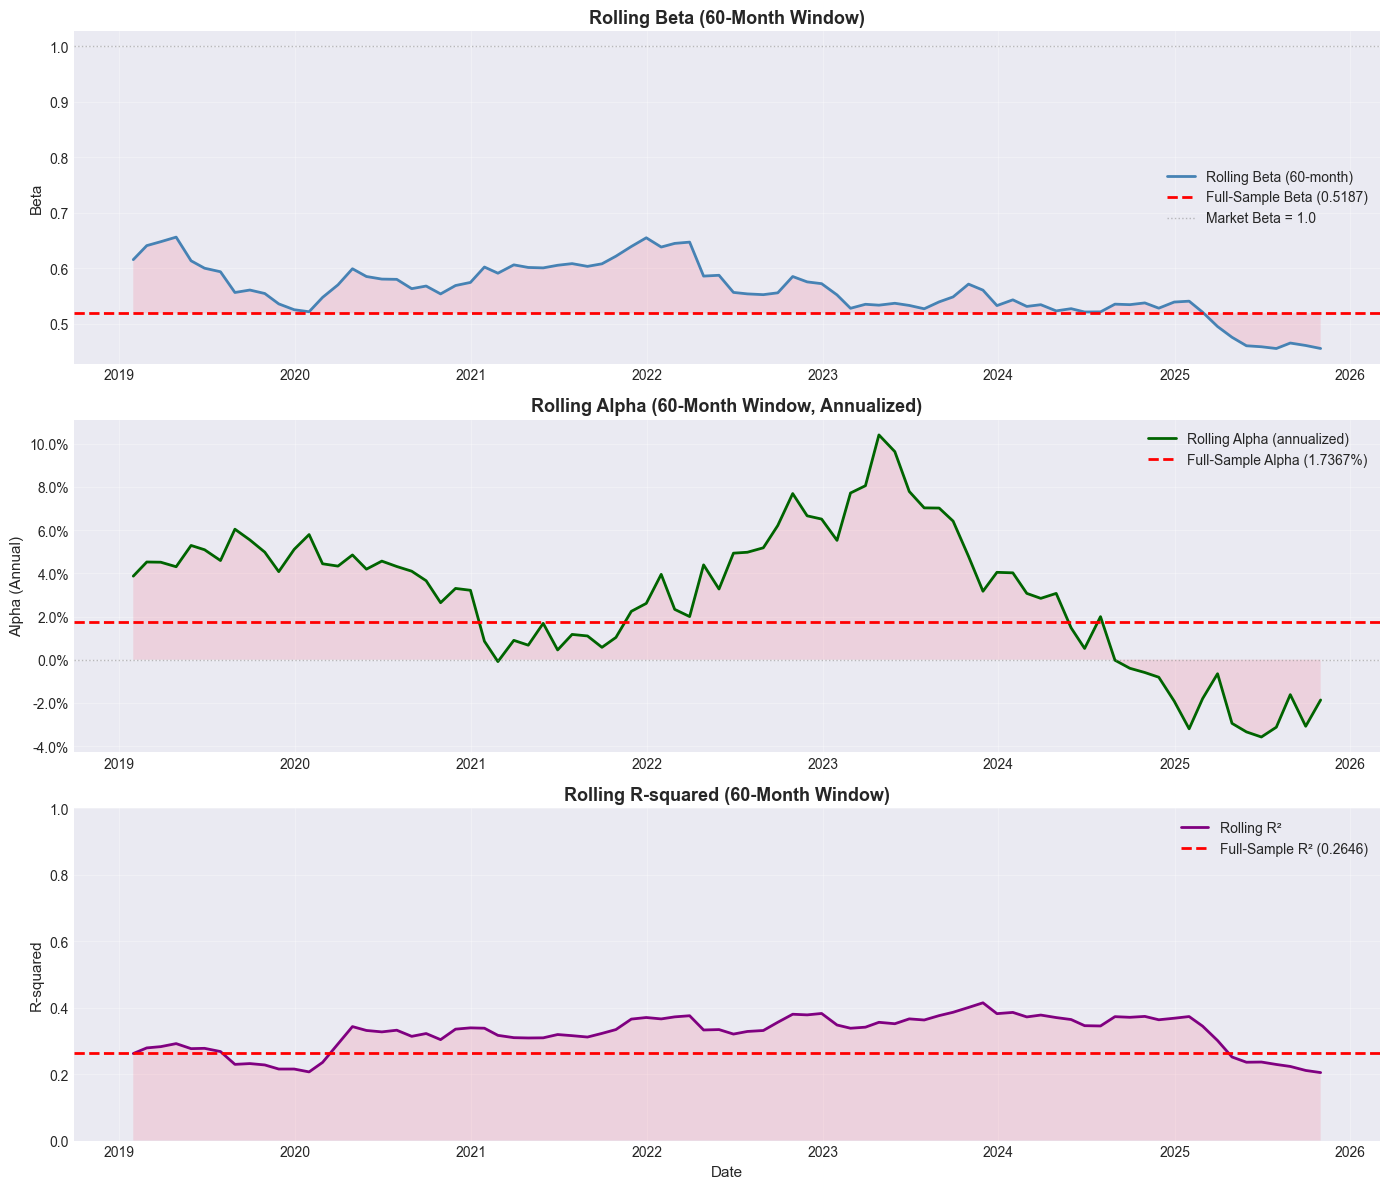

✅ Rolling regression parameters plotted successfully


In [7]:
# 4. Visualize rolling regression parameters
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Rolling Beta
axes[0].plot(rolling_df.index, rolling_df['beta'], linewidth=2, color='steelblue', label='Rolling Beta (60-month)')
axes[0].axhline(y=beta_full, color='red', linestyle='--', linewidth=2, label=f'Full-Sample Beta ({beta_full:.4f})')
axes[0].axhline(y=1.0, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Market Beta = 1.0')
axes[0].fill_between(rolling_df.index, rolling_df['beta'], beta_full, alpha=0.2)
axes[0].set_title('Rolling Beta (60-Month Window)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Beta', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling Alpha (annualized)
rolling_alpha_annual = rolling_df['alpha'] * 12
axes[1].plot(rolling_df.index, rolling_alpha_annual, linewidth=2, color='darkgreen', label='Rolling Alpha (annualized)')
axes[1].axhline(y=alpha_full*12, color='red', linestyle='--', linewidth=2, label=f'Full-Sample Alpha ({alpha_full*12:.4%})')
axes[1].axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
axes[1].fill_between(rolling_df.index, rolling_alpha_annual, 0, alpha=0.2)
axes[1].set_title('Rolling Alpha (60-Month Window, Annualized)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Alpha (Annual)', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Plot 3: Rolling R-squared
axes[2].plot(rolling_df.index, rolling_df['r_squared'], linewidth=2, color='purple', label='Rolling R²')
axes[2].axhline(y=r_squared_full, color='red', linestyle='--', linewidth=2, label=f'Full-Sample R² ({r_squared_full:.4f})')
axes[2].fill_between(rolling_df.index, rolling_df['r_squared'], alpha=0.2)
axes[2].set_title('Rolling R-squared (60-Month Window)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('R-squared', fontsize=11)
axes[2].legend(loc='best', fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("✅ Rolling regression parameters plotted successfully")

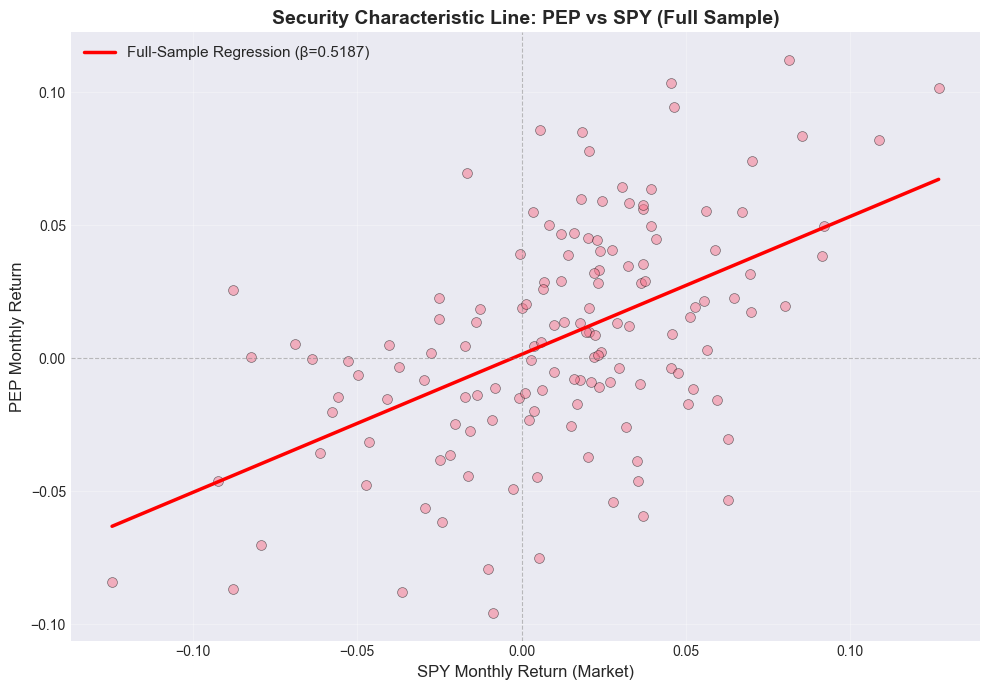

In [8]:
# 4b. Scatter plot with full-sample regression line (for reference)
X2 = np.linspace(X_full.min(), X_full.max(), 100)
Y_hat = X2 * beta_full + alpha_full

plt.figure(figsize=(10, 7))
plt.scatter(X_full, Y_full, alpha=0.5, s=50, edgecolor='black', linewidth=0.5)
plt.plot(X2, Y_hat, 'r-', linewidth=2.5, label=f'Full-Sample Regression (β={beta_full:.4f})')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.title('Security Characteristic Line: PEP vs SPY (Full Sample)', fontsize=14, fontweight='bold')
plt.xlabel('SPY Monthly Return (Market)', fontsize=12)
plt.ylabel('PEP Monthly Return', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# 5. Calculate comprehensive risk metrics using full-sample estimates
print("="*70)
print("RISK PROFILE ANALYSIS (Full-Sample Period)")
print("="*70)

# Use full-sample regression results
alpha = alpha_full
beta = beta_full
r_squared = r_squared_full
residuals = residuals_full

# Annualization factors
periods_per_year = 12  # monthly data
sqrt_periods = np.sqrt(periods_per_year)

# Basic statistics
pep_mean = clean_returns['PEP'].mean()
spy_mean = clean_returns['SPY'].mean()
pep_std = clean_returns['PEP'].std()
spy_std = clean_returns['SPY'].std()

# Annualized metrics
pep_annual_return = (1 + pep_mean) ** periods_per_year - 1
spy_annual_return = (1 + spy_mean) ** periods_per_year - 1
pep_annual_vol = pep_std * sqrt_periods
spy_annual_vol = spy_std * sqrt_periods

print(f"\n1. RETURN STATISTICS (Annualized)")
print(f"   PEP Average Return: {pep_annual_return:.4%}")
print(f"   SPY Average Return: {spy_annual_return:.4%}")
print(f"   Excess Return: {(pep_annual_return - spy_annual_return):.4%}")

print(f"\n2. TOTAL RISK (Standard Deviation - Annualized)")
print(f"   PEP Total Risk: {pep_annual_vol:.4%}")
print(f"   SPY Total Risk: {spy_annual_vol:.4%}")
print(f"   Risk Ratio: {pep_annual_vol / spy_annual_vol:.4f}")

print(f"\n3. SYSTEMATIC RISK")
print(f"   Beta: {beta:.4f}")
print(f"   Systematic Risk = Beta × Market Vol = {beta * spy_annual_vol:.4%}")

# Calculate unsystematic (residual) risk
residual_std = residuals.std() * sqrt_periods
print(f"\n4. UNSYSTEMATIC RISK (Diversifiable)")
print(f"   Residual Volatility: {residual_std:.4%}")
print(f"   % of Total Risk: {(residual_std / pep_annual_vol * 100):.2f}%")

# Total risk decomposition
systematic_risk = beta * spy_annual_vol
print(f"\n5. RISK DECOMPOSITION")
print(f"   Total Risk: {pep_annual_vol:.4%}")
print(f"   = Systematic Risk: {systematic_risk:.4%} ({systematic_risk/pep_annual_vol*100:.1f}%)")
print(f"   + Unsystematic Risk: {residual_std:.4%} ({residual_std/pep_annual_vol*100:.1f}%)")

# Rolling beta statistics
print(f"\n6. ROLLING BETA STATISTICS (60-Month Windows)")
print(f"   Average Beta: {rolling_df['beta'].mean():.4f}")
print(f"   Median Beta: {rolling_df['beta'].median():.4f}")
print(f"   Std Dev of Beta: {rolling_df['beta'].std():.4f}")
print(f"   Min Beta: {rolling_df['beta'].min():.4f} ({rolling_df['beta'].idxmin()})")
print(f"   Max Beta: {rolling_df['beta'].max():.4f} ({rolling_df['beta'].idxmax()})")
print(f"   Beta Range: {rolling_df['beta'].max() - rolling_df['beta'].min():.4f}")

RISK PROFILE ANALYSIS (Full-Sample Period)

1. RETURN STATISTICS (Annualized)
   PEP Average Return: 9.5383%
   SPY Average Return: 15.2561%
   Excess Return: -5.7178%

2. TOTAL RISK (Standard Deviation - Annualized)
   PEP Total Risk: 14.6987%
   SPY Total Risk: 14.5773%
   Risk Ratio: 1.0083

3. SYSTEMATIC RISK
   Beta: 0.5187
   Systematic Risk = Beta × Market Vol = 7.5611%

4. UNSYSTEMATIC RISK (Diversifiable)
   Residual Volatility: 12.5601%
   % of Total Risk: 85.45%

5. RISK DECOMPOSITION
   Total Risk: 14.6987%
   = Systematic Risk: 7.5611% (51.4%)
   + Unsystematic Risk: 12.5601% (85.5%)

6. ROLLING BETA STATISTICS (60-Month Windows)
   Average Beta: 0.5604
   Median Beta: 0.5559
   Std Dev of Beta: 0.0484
   Min Beta: 0.4551 (2025-07-31)
   Max Beta: 0.6560 (2019-04-30)
   Beta Range: 0.2009


In [10]:
# 6. Calculate performance metrics (assuming risk-free rate)
# For simplicity, using average 3-month T-bill rate ~2% annually, ~0.167% monthly
rf_annual = 0.02
rf_monthly = (1 + rf_annual) ** (1/12) - 1

print("="*70)
print("PERFORMANCE METRICS")
print("="*70)

# 1. Jensen's Alpha (from regression, already calculated)
jensens_alpha_monthly = alpha
jensens_alpha_annual = alpha * periods_per_year
print(f"\n1. JENSEN'S ALPHA (Ex-post)")
print(f"   Monthly: {jensens_alpha_monthly:.6f} ({jensens_alpha_monthly*100:.4f}%)")
print(f"   Annualized: {jensens_alpha_annual:.4%}")
print(f"   Interpretation: {'Outperformed' if jensens_alpha_annual > 0 else 'Underperformed'} market on risk-adjusted basis")

# 2. Sharpe Ratio
pep_excess_return = pep_annual_return - rf_annual
spy_excess_return = spy_annual_return - rf_annual
sharpe_pep = pep_excess_return / pep_annual_vol
sharpe_spy = spy_excess_return / spy_annual_vol

print(f"\n2. SHARPE RATIO (Risk-adjusted return)")
print(f"   PEP Sharpe: {sharpe_pep:.4f}")
print(f"   SPY Sharpe: {sharpe_spy:.4f}")
print(f"   Interpretation: PEP {'outperforms' if sharpe_pep > sharpe_spy else 'underperforms'} market per unit of total risk")

# 3. Treynor Ratio
treynor_pep = pep_excess_return / beta
treynor_spy = spy_excess_return / 1.0  # SPY beta = 1
print(f"\n3. TREYNOR RATIO (Excess return per unit of systematic risk)")
print(f"   PEP Treynor: {treynor_pep:.4%}")
print(f"   SPY Treynor: {treynor_spy:.4%}")
print(f"   Interpretation: Return per unit of beta (systematic risk only)")

# 4. Information Ratio (uses alpha and tracking error)
tracking_error = residuals.std() * sqrt_periods
info_ratio = jensens_alpha_annual / tracking_error
print(f"\n4. INFORMATION RATIO")
print(f"   Alpha: {jensens_alpha_annual:.4%}")
print(f"   Tracking Error: {tracking_error:.4%}")
print(f"   Information Ratio: {info_ratio:.4f}")
print(f"   Interpretation: Alpha per unit of active risk")

# 5. Sortino Ratio (downside deviation)
downside_returns = clean_returns['PEP'][clean_returns['PEP'] < rf_monthly]
downside_std = downside_returns.std() * sqrt_periods
sortino_pep = pep_excess_return / downside_std
print(f"\n5. SORTINO RATIO (Downside risk-adjusted)")
print(f"   Downside Deviation: {downside_std:.4%}")
print(f"   Sortino Ratio: {sortino_pep:.4f}")
print(f"   Interpretation: Return per unit of downside risk only")

# 6. Maximum Drawdown
cumulative_returns = (1 + clean_returns['PEP']).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()
print(f"\n6. MAXIMUM DRAWDOWN")
print(f"   Max Drawdown: {max_drawdown:.4%}")
print(f"   Date: {drawdown.idxmin()}")

# 7. Return to Risk metrics
return_to_vol = pep_annual_return / pep_annual_vol
return_to_maxdd = pep_annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
print(f"\n7. RETURN-TO-RISK RATIOS")
print(f"   Return/Volatility: {return_to_vol:.4f}")
print(f"   Return/MaxDD: {return_to_maxdd:.4f}")

PERFORMANCE METRICS

1. JENSEN'S ALPHA (Ex-post)
   Monthly: 0.001447 (0.1447%)
   Annualized: 1.7367%
   Interpretation: Outperformed market on risk-adjusted basis

2. SHARPE RATIO (Risk-adjusted return)
   PEP Sharpe: 0.5129
   SPY Sharpe: 0.9094
   Interpretation: PEP underperforms market per unit of total risk

3. TREYNOR RATIO (Excess return per unit of systematic risk)
   PEP Treynor: 14.5335%
   SPY Treynor: 13.2561%
   Interpretation: Return per unit of beta (systematic risk only)

4. INFORMATION RATIO
   Alpha: 1.7367%
   Tracking Error: 12.5601%
   Information Ratio: 0.1383
   Interpretation: Alpha per unit of active risk

5. SORTINO RATIO (Downside risk-adjusted)
   Downside Deviation: 8.8538%
   Sortino Ratio: 0.8514
   Interpretation: Return per unit of downside risk only

6. MAXIMUM DRAWDOWN
   Max Drawdown: -26.7409%
   Date: 2025-05-30

7. RETURN-TO-RISK RATIOS
   Return/Volatility: 0.6489
   Return/MaxDD: 0.3567


In [11]:
# 7. Summary table of all risk metrics
summary_data = {
    'Metric': [
        'Average Annual Return',
        'Total Risk (Volatility)',
        'Beta (Systematic Risk)',
        'Unsystematic Risk',
        "Jensen's Alpha",
        'Sharpe Ratio',
        'Treynor Ratio',
        'Information Ratio',
        'Sortino Ratio',
        'Maximum Drawdown',
        'R-squared'
    ],
    'PEP': [
        f"{pep_annual_return:.4%}",
        f"{pep_annual_vol:.4%}",
        f"{beta:.4f}",
        f"{residual_std:.4%}",
        f"{jensens_alpha_annual:.4%}",
        f"{sharpe_pep:.4f}",
        f"{treynor_pep:.4%}",
        f"{info_ratio:.4f}",
        f"{sortino_pep:.4f}",
        f"{max_drawdown:.4%}",
        f"{r_squared:.4f}"
    ],
    'SPY (Benchmark)': [
        f"{spy_annual_return:.4%}",
        f"{spy_annual_vol:.4%}",
        "1.0000",
        "N/A",
        "0.00%",
        f"{sharpe_spy:.4f}",
        f"{treynor_spy:.4%}",
        "N/A",
        "N/A",
        "N/A",
        "1.0000"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("COMPREHENSIVE RISK PROFILE SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("\n" + "="*70)


COMPREHENSIVE RISK PROFILE SUMMARY
                 Metric       PEP SPY (Benchmark)
  Average Annual Return   9.5383%        15.2561%
Total Risk (Volatility)  14.6987%        14.5773%
 Beta (Systematic Risk)    0.5187          1.0000
      Unsystematic Risk  12.5601%             N/A
         Jensen's Alpha   1.7367%           0.00%
           Sharpe Ratio    0.5129          0.9094
          Treynor Ratio  14.5335%        13.2561%
      Information Ratio    0.1383             N/A
          Sortino Ratio    0.8514             N/A
       Maximum Drawdown -26.7409%             N/A
              R-squared    0.2646          1.0000



## Summary and Interpretation

### Key Findings:

1. **Systematic Risk (Beta)**:
   - Beta measures sensitivity to market movements
   - Beta > 1: Stock is more volatile than market (aggressive)
   - Beta < 1: Stock is less volatile than market (defensive)

2. **Total Risk Decomposition**:
   - Total Risk = Systematic Risk + Unsystematic Risk
   - Systematic risk cannot be diversified away
   - Unsystematic risk can be eliminated through diversification

3. **Performance Metrics**:
   - **Jensen's Alpha**: Excess return after adjusting for market risk (beta)
   - **Sharpe Ratio**: Return per unit of total risk
   - **Treynor Ratio**: Return per unit of systematic risk (beta)
   - **Information Ratio**: Alpha per unit of tracking error (active risk)
   - **Sortino Ratio**: Return per unit of downside risk only

4. **Risk-Return Tradeoff**:
   - Higher risk should be compensated with higher returns
   - Compare PEP metrics to SPY benchmark to assess performance
   - Positive alpha indicates outperformance on risk-adjusted basis

### Investment Implications:
- Use beta for portfolio construction and hedging
- Use Sharpe/Treynor ratios to compare risk-adjusted performance
- Monitor maximum drawdown for downside risk management
- Alpha indicates manager skill or model effectiveness